# **Generating Pokemon Images - DCGAN**

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kvpratama/pokemon-images-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 70.9M/70.9M [00:04<00:00, 20.4MB/s]
100% 70.9M/70.9M [00:04<00:00, 17.1MB/s]


In [4]:
! unzip /content/pokemon-images-dataset.zip

Archive:  /content/pokemon-images-dataset.zip
  inflating: pokemon/pokemon/1.png   
  inflating: pokemon/pokemon/10.png  
  inflating: pokemon/pokemon/100.png  
  inflating: pokemon/pokemon/101.png  
  inflating: pokemon/pokemon/102.png  
  inflating: pokemon/pokemon/103.png  
  inflating: pokemon/pokemon/104.png  
  inflating: pokemon/pokemon/105.png  
  inflating: pokemon/pokemon/106.png  
  inflating: pokemon/pokemon/107.png  
  inflating: pokemon/pokemon/108.png  
  inflating: pokemon/pokemon/109.png  
  inflating: pokemon/pokemon/11.png  
  inflating: pokemon/pokemon/110.png  
  inflating: pokemon/pokemon/111.png  
  inflating: pokemon/pokemon/112.png  
  inflating: pokemon/pokemon/113.png  
  inflating: pokemon/pokemon/114.png  
  inflating: pokemon/pokemon/115-mega.png  
  inflating: pokemon/pokemon/115.png  
  inflating: pokemon/pokemon/116.png  
  inflating: pokemon/pokemon/117.png  
  inflating: pokemon/pokemon/118.png  
  inflating: pokemon/pokemon/119.png  
  inflating: pok

In [11]:
import numpy as np

import torch
from torch import FloatTensor, LongTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [14]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
        transforms.Normalize(mean = (0.5), std = (0.5))
    ]
)

In [15]:
data = ImageFolder(root = "/content/pokemon", transform = transform)
data

Dataset ImageFolder
    Number of datapoints: 819
    Root location: /content/pokemon
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               Normalize(mean=0.5, std=0.5)
           )

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


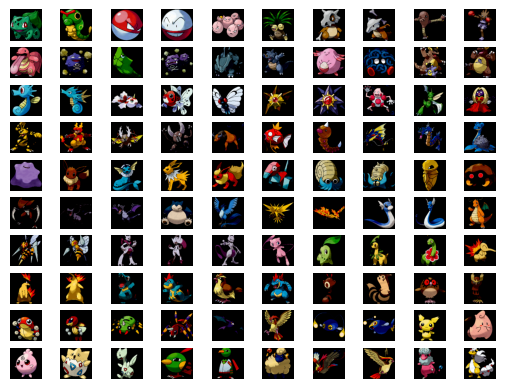

In [19]:
fig = plt.figure()

for i in range(100):
  fig.add_subplot(10, 10, i + 1)
  plt.imshow(data[i][0].permute(1, 2, 0))
  plt.axis("off")

In [20]:
data_loader = DataLoader(data, batch_size = 25, shuffle = True)

In [21]:
import torch.nn as nn

In [39]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        # in: 3 x 128 x 128

        nn.Conv2d(3, 16, kernel_size = 4, padding = 1, stride = 2, bias = False),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2, inplace = True),
        # out: 16 x 64 x 64

        nn.Conv2d(16, 64, kernel_size = 4, padding = 1, stride = 2, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True),
        # out: 64 x 32 x 32

        nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),
        # out: 128 x 16 x 16

        nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),
        # out: 256 x 8 x 8

        nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),
        # out: 512 x 4 x 4

        nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
        # out: 1 x 1 x 1

        nn.Flatten(),
        # out: 1

        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [38]:
latent_dim = 256

class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        # in: 256 x 1 x 1

        nn.ConvTranspose2d(latent_dim, 512, kernel_size = 4, padding = 0, stride = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True),
        # out: 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, kernel_size = 4, padding = 1, stride = 2, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True),
        # out: 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, kernel_size = 4, padding = 1, stride = 2, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True),
        # out: 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, kernel_size = 4, padding = 1, stride = 2, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        # out: 64 x 32 x 32

        nn.ConvTranspose2d(64, 32, kernel_size = 4, padding = 1, stride = 2, bias = False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace = True),
        # out: 32 x 64 x 64

        nn.ConvTranspose2d(32, 3, kernel_size = 4, padding = 1, stride = 2, bias = False),
        # out: 3 x 128 x 128

        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [41]:
loss_fn = nn.BCELoss()

optim_g = torch.optim.Adam(generator.parameters(), lr = 0.0002)
optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.0002)

In [28]:
import os
from torchvision.utils import save_image

In [46]:
epochs = 100

for epoch in range(epochs):
  for b, (real_imgs, _) in enumerate(data_loader):
    real_imgs = real_imgs.to(device)

    real_labels = torch.ones(len(real_imgs), 1).to(device)
    fake_labels = torch.zeros(len(real_imgs), 1).to(device)

    # Training -> Generator
    x = torch.randn(len(real_imgs), latent_dim, 1, 1).to(device)
    fake_imgs = generator(x).to(device)
    g_loss = loss_fn(discriminator(fake_imgs), real_labels)
    optim_g.zero_grad()
    g_loss.backward()
    optim_g.step()

    # Training -> Discriminator
    d_loss_real = loss_fn(discriminator(real_imgs), real_labels)
    d_loss_fake = loss_fn(discriminator(fake_imgs.detach()), fake_labels)
    d_loss = (d_loss_real + d_loss_fake) / 2
    optim_d.zero_grad()
    d_loss.backward()
    optim_d.step()

    if (b + 1) % 10 == 0:
            print(f"[Epoch {epoch + 1}] [Batch {b + 1}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

  # Save generated images
  os.makedirs("Images", exist_ok = True)
  save_image(fake_imgs.view(fake_imgs.size(0), 3, 128, 128), f"Images/{epoch + 1}.png", normalize = True)


[Epoch 1] [Batch 10] [D loss: 0.0011273728450760245] [G loss: 10.551403999328613]
[Epoch 1] [Batch 20] [D loss: 0.0013461209600791335] [G loss: 11.516654968261719]
[Epoch 1] [Batch 30] [D loss: 0.0813639760017395] [G loss: 9.73089599609375]
[Epoch 2] [Batch 10] [D loss: 0.20080891251564026] [G loss: 3.12833571434021]
[Epoch 2] [Batch 20] [D loss: 0.011827156879007816] [G loss: 17.680845260620117]
[Epoch 2] [Batch 30] [D loss: 9.868004417512566e-05] [G loss: 16.577116012573242]
[Epoch 3] [Batch 10] [D loss: 0.009496054612100124] [G loss: 6.003367900848389]
[Epoch 3] [Batch 20] [D loss: 0.049961868673563004] [G loss: 8.0030517578125]
[Epoch 3] [Batch 30] [D loss: 0.039021413773298264] [G loss: 4.236174583435059]
[Epoch 4] [Batch 10] [D loss: 0.05393437668681145] [G loss: 6.131653785705566]
[Epoch 4] [Batch 20] [D loss: 0.07075116783380508] [G loss: 6.061486721038818]
[Epoch 4] [Batch 30] [D loss: 0.07453603297472] [G loss: 6.787580966949463]
[Epoch 5] [Batch 10] [D loss: 0.03103611804544

## **Generated Images (350 Epochs)**

In [47]:
from PIL import Image

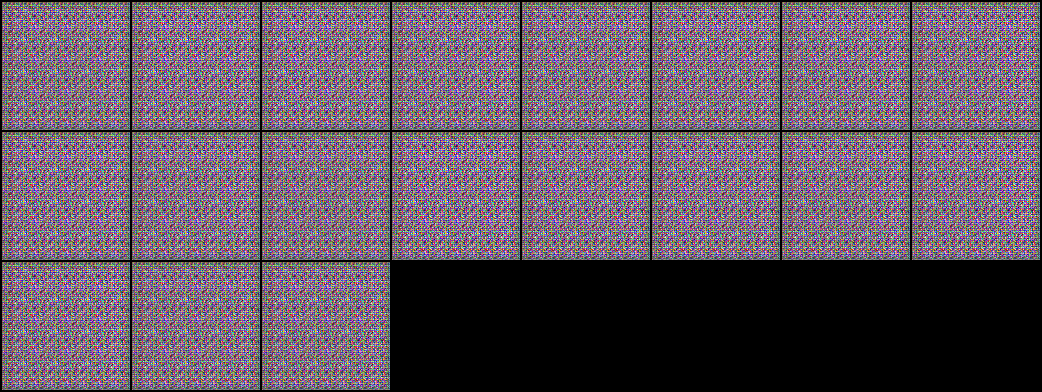

In [49]:
# Generated Images - Epoch 1
Image.open("images/1.png")

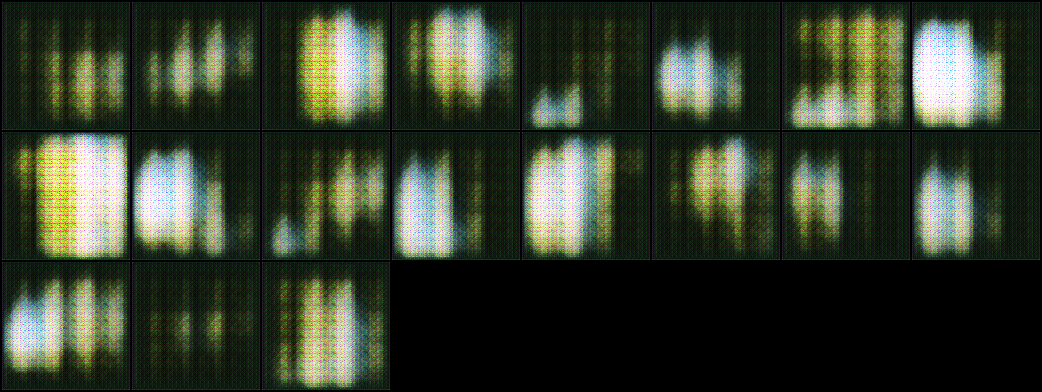

In [50]:
# Generated Images - Epoch 25
Image.open("images/25.png")

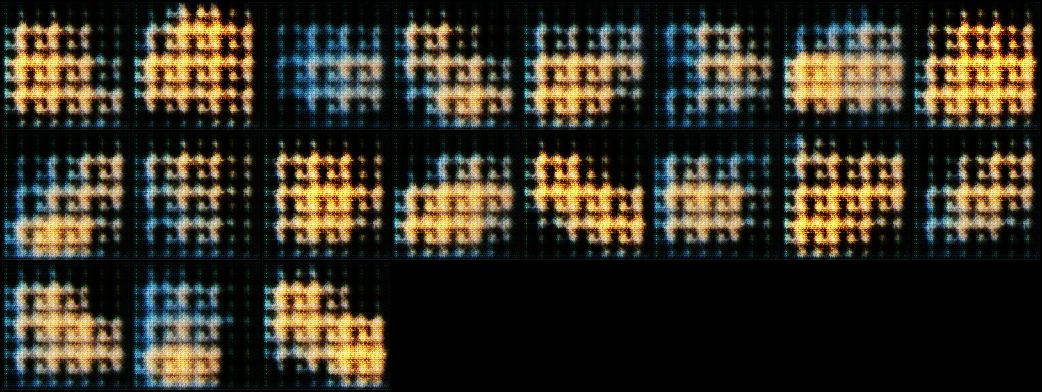

In [51]:
# Generated Images - Epoch 50
Image.open("images/50.png")

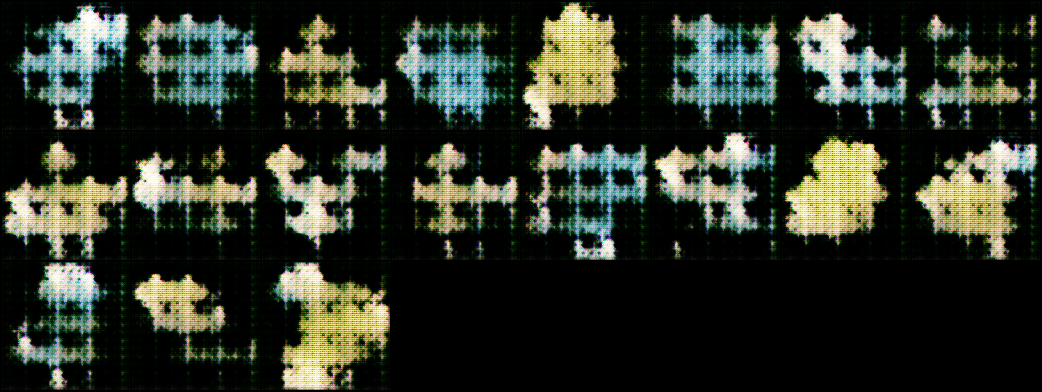

In [52]:
# Generated Images - Epoch 100
Image.open("image/50.png")

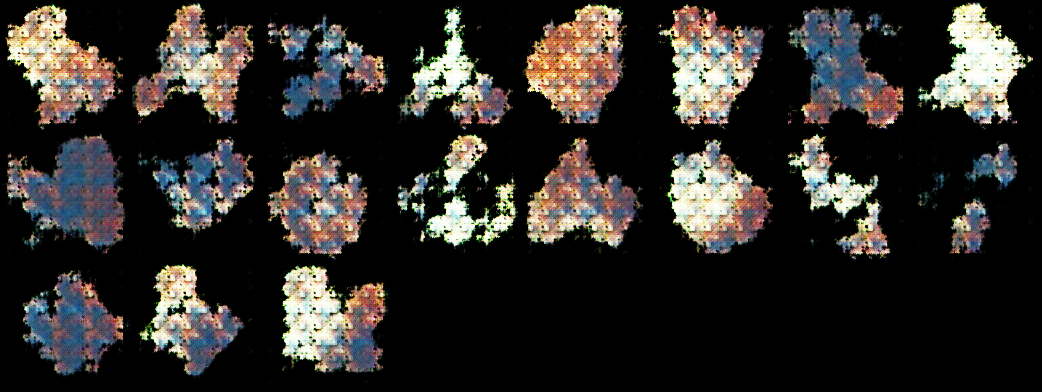

In [53]:
# Generated Images - Epoch 175
Image.open("Images/25.png")

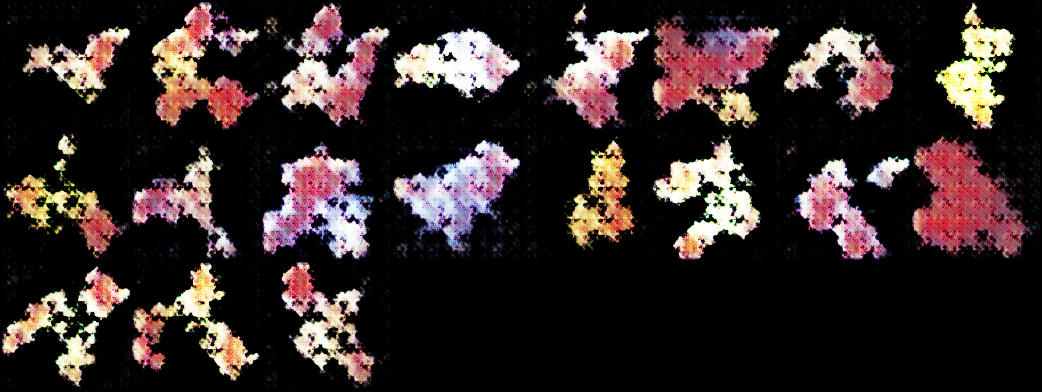

In [54]:
# Generated Images - Epoch 249
Image.open("Image/99.png")

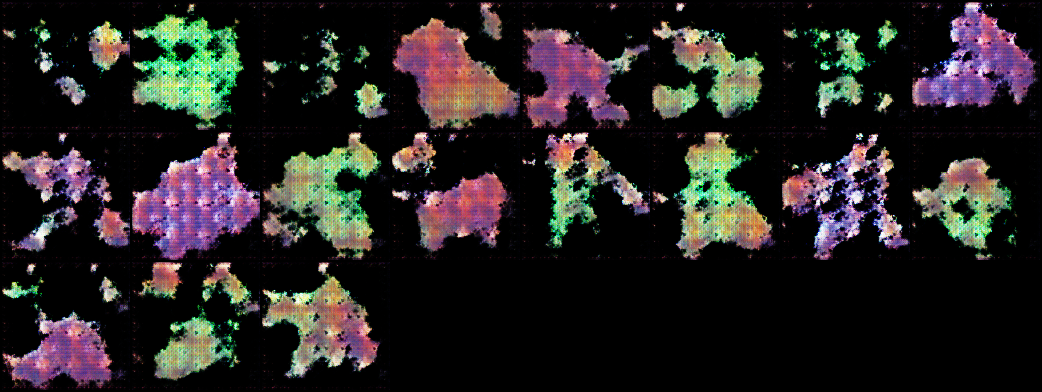

In [55]:
# Generated Images - Epoch 284
Image.open("Images/34.png")

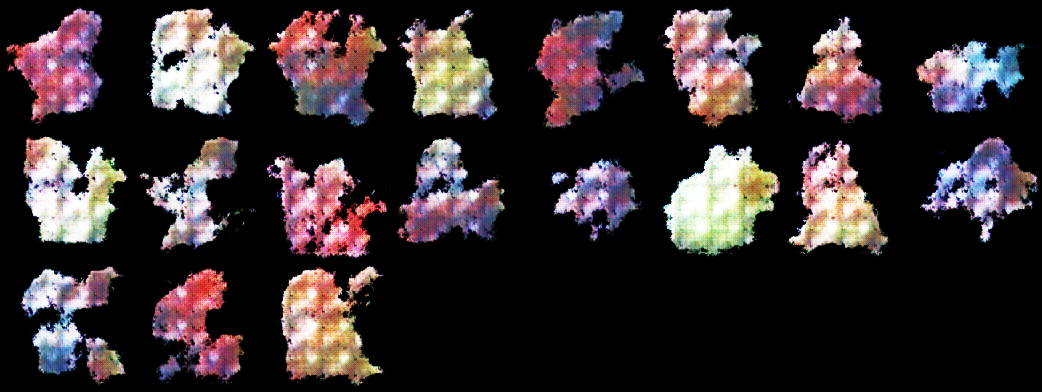

In [56]:
# Generated Images - Epoch 326
Image.open("Images/76.png")

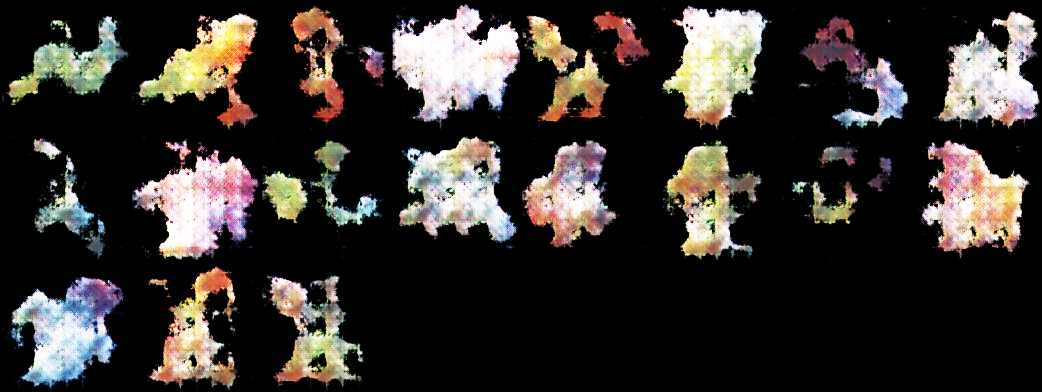

In [57]:
# Generated Images - Epoch 337
Image.open("Images/87.png")

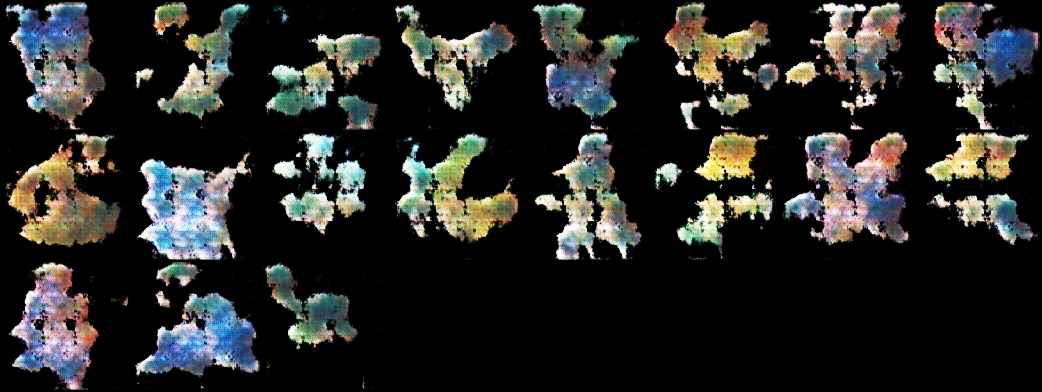

In [58]:
# Generated Images - Epoch 348
Image.open("Images/98.png")

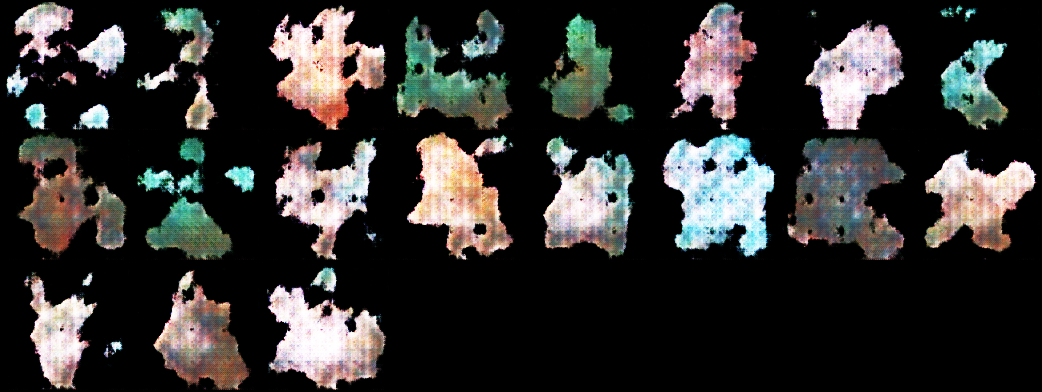

In [59]:
# Generated Images - Epoch 350
Image.open("Images/100.png")